# Time Series forecasting using Recurrent Neural Network
May 13, 2019. Guorui Shen, guorui233@outlook.com.

- This notebook is adapted from https://github.com/guillaume-chevalier/seq2seq-signal-prediction, which is quite complicated to understand due to many internal function calls.
- RNN adopted in this notebook is built on Tensorflow.

Detailed information:
+ Sampled from a two-component system, time series considered in this demo is 
\begin{align}
u_i=\left[sin(t_i), cos(t_i)\right],
\end{align}
with $2000$ equally spaced time points $t_1,t_2,\cdots,t_{2000}$ distributed over the interval $[0, 18\pi]$.
+ Neural Network (NN) we used in here contains an encoder and a decoder. Features and labels are chosen such that
$$NN(u_{k-\text{timesteps}}, \cdots, u_{k-2}, u_{k-1}) = u_{k},u_{k+1}, \cdots, u_{k+\text{timesteps}-1}$$
i.e. NN maps from past observations to the same amount of future next observations.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1 Original data

In [2]:
T = np.linspace(0, 18.0 * np.pi, 2000)
sig1 = np.sin(T).reshape(-1,1)
sig2 = np.cos(T).reshape(-1,1)
data = np.hstack((sig1, sig2))
print(data.shape)

(2000, 2)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,u't')

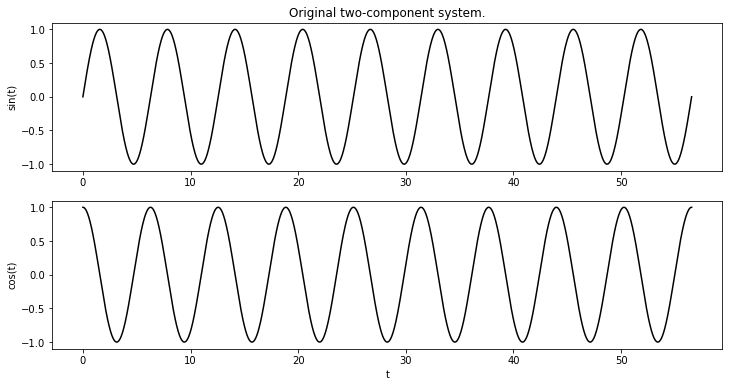

In [3]:
ylabel = ['sin(t)', 'cos(t)']
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Original two-component system.')
for i in range(2):
    plt.subplot(211+i)
    plt.plot(T, data[:,i], 'k-')
    plt.ylabel(ylabel[i])
plt.xlabel('t')

## 2 Pick up needed features and labels

In [4]:
timesteps = 10
batch_size = 32
output_dim = input_dim = 2
num_train = 700 # number of examples for training
# num_test = len(data)-num_train-timesteps # number of examples for testing

In [5]:
# features and labels for training model
features_train = np.empty(shape=(0, timesteps, input_dim))
labels_train = np.empty(shape=(0, timesteps, output_dim))
for i in range(num_train):
    features_train = np.vstack((features_train, data[i:i+timesteps, :].reshape(-1,timesteps,input_dim)))
    labels_train = np.vstack((labels_train, data[i+timesteps:i+2*timesteps, :].reshape(-1,timesteps,output_dim)))
print(features_train.shape, labels_train.shape)

((700, 10, 2), (700, 10, 2))


In [6]:
# features and labels for testing model
i = num_train
features_test_input = data[i:i+timesteps, :].reshape(timesteps,1,input_dim)
labels_test = data[i+timesteps:, :]
print(features_test_input.shape, labels_test.shape)

# for plotting
T_train = T[:i+timesteps]
T_test = T[i+timesteps:]

((10, 1, 2), (1290, 2))


In [7]:
# Internal neural network parameters
hidden_dim = 12  # Count of hidden neurons in the recurrent units. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
num_iter = 3000  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5   # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

## 3 Define the seq2seq neural network

<img src="https://www.tensorflow.org/images/basic_seq2seq.png" />

Comparatively to what we see in the image, our neural network deals with signal rather than letters. Also, we don't have the feedback mechanism yet. 

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Encoder input: (timesteps, batch_size, input_dim)
encoder_input = [
    tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
       for t in range(timesteps)]

# Decoder input: (timesteps, batch_size, output_dim)
decoder_input = [ tf.zeros_like(encoder_input[0], dtype=np.float32, name="GO") ] + encoder_input[:-1]

# expected outputs: (timesteps, batch_size, output_dim)
expected_output = [
    tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_output".format(t))
      for t in range(timesteps)]

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(hidden_dim), tf.contrib.rnn.BasicRNNCell(hidden_dim)])
# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(hidden_dim), tf.contrib.rnn.GRUCell(hidden_dim)])
# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(hidden_dim), tf.contrib.rnn.BasicLSTMCell(hidden_dim)])
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(hidden_dim), tf.contrib.rnn.LSTMCell(hidden_dim)])

# This model first runs an RNN to encode encoder_inputs into a state vector, then runs decoder, initialized
# with the last encoder state, on decoder_inputs. Encoder and decoder use the same RNN cell type, but don't 
# share parameters.
# 
# dec_outputs is a list with length "timesteps" whose element has shape of [batch_size, hidden_dim]. 
# dec_state: [batch_size, hidden_dim].
decoder_outputs, decoder_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(
    encoder_input,
    decoder_input,
    cell)

In [9]:
w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
b_out = tf.Variable(tf.random_normal([output_dim]))

# (timesteps, batch_size, output_dim)
predictor = [tf.matmul(i, w_out) + b_out for i in decoder_outputs]

In [10]:
# Training loss and optimizer
loss = 0
for _y, _Y in zip(predictor, expected_output):
    loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    
optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
train_op = optimizer.minimize(loss)

## 4 Train the neural network

In [11]:
def next_batch(x, y, batch_size):
    N = x.shape[0]
    batch_indices = np.random.permutation(N)[:batch_size]
    return x[batch_indices], y[batch_indices]

# Training
train_losses = []
sess.run(tf.global_variables_initializer())
for t in range(0, num_iter+1):

    # both batch_features_tmp and batch_labels_tmp are of the shape: (batch_size, timesteps, output_dim)
    batch_features_tmp, batch_labels_tmp = next_batch(features_train, labels_train, batch_size)
    
    # both batch_features and batch_labels are of the shape: (timesteps, batch_size, output_dim)
    batch_features = batch_features_tmp.transpose((1,0,2))
    batch_labels = batch_labels_tmp.transpose((1,0,2))
    
    feed_dict = {encoder_input[t]: batch_features[t] for t in range(timesteps)}
    feed_dict.update({expected_output[t]: batch_labels[t] for t in range(timesteps)})
    _, train_loss = sess.run([train_op, loss], feed_dict)
    
    train_losses.append(train_loss)
    if t%300==0:
        print("Training step {}, loss is {:.6}".format(t, train_loss))
print('Training process finished!')

Training step 0, loss is 185.08
Training step 300, loss is 0.090634
Training step 600, loss is 0.480559
Training step 900, loss is 0.120644
Training step 1200, loss is 0.292415
Training step 1500, loss is 0.0105935
Training step 1800, loss is 0.0767603
Training step 2100, loss is 0.06134
Training step 2400, loss is 0.0516892
Training step 2700, loss is 0.16267
Training step 3000, loss is 0.0670106
Training process finished!


Text(0,0.5,u'training error')

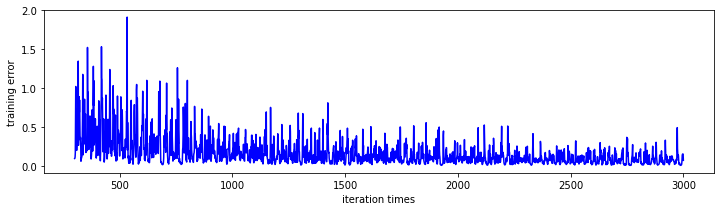

In [12]:
plt.figure(figsize=(12,3))
plt.plot(range(300, num_iter+1), train_losses[300:], 'b-')
plt.xlabel('iteration times')
plt.ylabel('training error')

## 5 Predict future values

In [13]:
results = np.empty((0,output_dim))
for t in range(129):
    feed_dict = {encoder_input[t]: features_test_input[t] for t in range(timesteps)}
    features_test_input = sess.run(predictor, feed_dict)
    results = np.vstack((results, np.array(features_test_input).reshape(timesteps, output_dim)))
print(results.shape)

(1290, 2)


In [14]:
print(labels_test.shape)

(1290, 2)


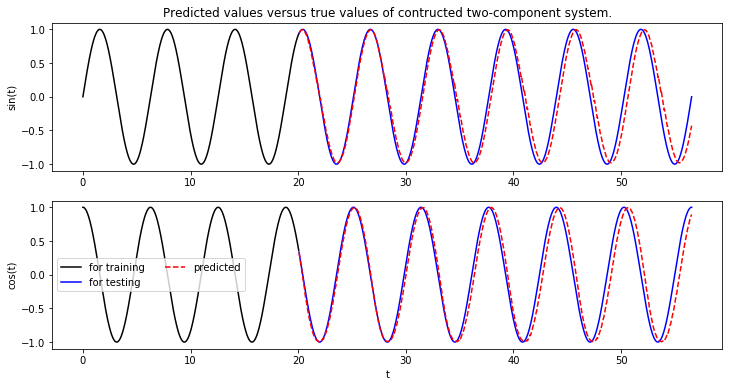

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Predicted values versus true values of contructed two-component system.')
for i in range(output_dim):
    plt.subplot(211+i)
    plt.plot(T_train, data[:num_train+timesteps, i], 'k-', \
             T_test, labels_test[:,i], 'b-', T_test, results[:,i], 'r--')
    plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["for training","for testing", "predicted"], loc = 0, ncol = 2)

In [16]:
sess.close()